In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# 'problem' klasörünün içeriğini listeleyelim
os.listdir('/content/drive/MyDrive/NPSMap/data/excels/KUTU')


['kutuGpt.xlsx',
 'kutuAltR.ipynb',
 'kutuGptAltR.xlsx',
 'kutu.xlsx',
 'ALTR_BERT_LOAD.ipynb adlı dosyanın kopyası']

In [ ]:
import pandas as pd
from torch.optim import AdamW
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np

In [ ]:
file_path='/content/drive/MyDrive/NPSMap/data/excels/KUTU P5/kutuHata.xlsx'
df = pd.read_excel(file_path)
gercek_df = pd.read_excel("/content/drive/MyDrive/NPSMap/data/excels/KUTU P5/kutu.xlsx")




In [ ]:
df.head()
nan_rows = df[df["MAP"].isna()]
nan_rows = df[df["Yorum"].isna()]

print(nan_rows)

Empty DataFrame
Columns: [Yorum, MAP, Unnamed: 2, Unnamed: 3, Unnamed: 4, Unnamed: 5, Unnamed: 6, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10, Unnamed: 11, Unnamed: 12, Unnamed: 13, Unnamed: 14, Unnamed: 15, Unnamed: 16]
Index: []


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3935 entries, 0 to 3934
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Yorum        3935 non-null   object
 1   MAP          3935 non-null   object
 2   Unnamed: 2   3935 non-null   object
 3   Unnamed: 3   2 non-null      object
 4   Unnamed: 4   2 non-null      object
 5   Unnamed: 5   2 non-null      object
 6   Unnamed: 6   2 non-null      object
 7   Unnamed: 7   2 non-null      object
 8   Unnamed: 8   2 non-null      object
 9   Unnamed: 9   2 non-null      object
 10  Unnamed: 10  2 non-null      object
 11  Unnamed: 11  2 non-null      object
 12  Unnamed: 12  2 non-null      object
 13  Unnamed: 13  2 non-null      object
 14  Unnamed: 14  2 non-null      object
 15  Unnamed: 15  2 non-null      object
 16  Unnamed: 16  2 non-null      object
dtypes: object(17)
memory usage: 522.7+ KB


In [ ]:
df = df[['Yorum', 'MAP']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3935 entries, 0 to 3934
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Yorum   3935 non-null   object
 1   MAP     3935 non-null   object
dtypes: object(2)
memory usage: 61.6+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3935 entries, 0 to 3934
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Yorum   3935 non-null   object
 1   MAP     3935 non-null   object
dtypes: object(2)
memory usage: 61.6+ KB


In [ ]:
df.duplicated().sum()

np.int64(12)

In [ ]:
df[df.duplicated()]


Yorum                   MAP
1131  Gebze center mağazası kutular karışmış fiyatla...  Hatalı Reason Seçimi
2237  Yaptığım hediye çekiyle maalesef istediğim ürü...  Hatalı Reason Seçimi
2290  Kasayeriniz çok ukala idi koş koca magzada 1 t...  Hatalı Reason Seçimi
2327  Çalışan yok bütün ürünleri kendim bulmaya çalı...  Hatalı Reason Seçimi
2346  Aldığım ürünün etiket fiyatı başka kasa fiyatı...  Hatalı Reason Seçimi
2544  Polo bot 36 siparişim 38 geldi kutusu doğru iç...  Hatalı Reason Seçimi
2546  Merhaba, siparişimde farklı bir ayakkabı sipar...  Hatalı Reason Seçimi
2548  Farkıli renk bot geldi ve botun taban tarafınd...  Hatalı Reason Seçimi
2551  aldığım her iki bot özellikle micelancelo 43 n...  Hatalı Reason Seçimi
2913  Hediye paketi sunulmaması, mağazanın müşteri m...          Dogru Reason
3815  Kutusu o kadar kötüydü ki, ürünü almak neredey...          Dogru Reason
3895  Kutusu o kadar kirli ve yıpranmıştı ki, ürünü ...          Dogru Reason

In [ ]:
df["MAP"].value_counts()

MAP
Hatalı Reason Seçimi    2552
Dogru Reason            1383
Name: count, dtype: int64

In [ ]:
gercek_df["MAP"].value_counts()

MAP
Dogru Reason            190
Hatalı Reason Seçimi     10
Name: count, dtype: int64

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['MAP'].values)
labels_gercek = label_encoder.transform(gercek_df['MAP'].values)
label_encoder.classes_

array(['Dogru Reason', 'Hatalı Reason Seçimi'], dtype=object)

In [ ]:
label_sayisi=len(label_encoder.classes_)

In [ ]:
label_encoder.classes_

array(['Dogru Reason', 'Hatalı Reason Seçimi'], dtype=object)

In [ ]:
model_name = "/content/drive/MyDrive/NPSMap/models/hatalıR/KUTU/KUTU 99/bert_finetuned_model"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

In [ ]:
if torch.cuda.is_available():
    print("GPU kullanılabilir.")
else:
    print("GPU kullanılabilir değil. CPU kullanılıyor.")

GPU kullanılabilir değil. CPU kullanılıyor.


In [ ]:
import torch

# PyTorch sürümünü yazdır
print("PyTorch Sürümü:", torch.__version__)

# CUDA'nın kullanılabilirliğini kontrol et ve versiyonunu yazdır
if torch.cuda.is_available():
    print("CUDA Sürümü:", torch.version.cuda)
    print("CUDA kullanılabilir ve GPU kullanılıyor.")
else:
    print("CUDA kullanılabilir değil. CPU kullanılıyor.")

PyTorch Sürümü: 2.6.0+cu124
CUDA kullanılabilir değil. CPU kullanılıyor.


In [ ]:
def tokenize_data(texts):
    texts = texts.tolist()
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=256)

X_train, X_test, y_train, y_test = train_test_split(df['Yorum'], labels, test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42,stratify=y_train)

len(X_train),len(X_test), len(X_val)


(3186, 394, 355)

In [ ]:
print("Eğitim seti dağılımı:")
print(pd.Series(y_train).value_counts())

print("\nTest seti dağılımı:")
print(pd.Series(y_test).value_counts())

print("\nDoğrulama seti dağılımı:")
print(pd.Series(y_val).value_counts())



Eğitim seti dağılımı:
1    2066
0    1120
Name: count, dtype: int64

Test seti dağılımı:
1    256
0    138
Name: count, dtype: int64

Doğrulama seti dağılımı:
1    230
0    125
Name: count, dtype: int64


In [ ]:
train_inputs = tokenize_data(X_train)
val_inputs = tokenize_data(X_val)
test_inputs = tokenize_data(X_test)

In [ ]:
def decode_tokens(input_ids):
    return tokenizer.batch_decode(input_ids, skip_special_tokens=True)

decoded_train_texts = decode_tokens(train_inputs['input_ids'][:5])
decoded_val_texts = decode_tokens(val_inputs['input_ids'][:5])
decoded_test_texts = decode_tokens(test_inputs['input_ids'][:5])

# train_batch değişkenini bu noktada tanımlayın
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], torch.tensor(y_train, dtype=torch.long))
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
train_batch = next(iter(train_dataloader)) # train_batch burada tanımlanıyor

decoded_train_texts = decode_tokens(train_batch[0][:2])  # İlk 2 örneği dönüştür
print("Decoded Train Batch Texts (İlk 2 örnek):\n", decoded_train_texts)

print("\nTokenize Edilmiş Train Metinleri (İlk 5 örnek):\n", decoded_train_texts)
print("\nTokenize Edilmiş Val Metinleri (İlk 5 örnek):\n", decoded_val_texts)
print("\nTokenize Edilmiş Test Metinleri (İlk 5 örnek):\n", decoded_test_texts)

# ... (Geri kalan kodunuz)

Decoded Train Batch Texts (İlk 2 örnek):
 ['Poşet parası almak alışverişin sonunu biraz kötüleştiriyor, özellikle de küçük bir şey aldığınızda.', 'Alarmı sökülmeden gelen ürünle mağaza çıkışında alarm öttü, gerçekten çok zaman kaybettim ve mağaza ilgilenmedi.']

Tokenize Edilmiş Train Metinleri (İlk 5 örnek):
 ['Poşet parası almak alışverişin sonunu biraz kötüleştiriyor, özellikle de küçük bir şey aldığınızda.', 'Alarmı sökülmeden gelen ürünle mağaza çıkışında alarm öttü, gerçekten çok zaman kaybettim ve mağaza ilgilenmedi.']

Tokenize Edilmiş Val Metinleri (İlk 5 örnek):
 ['Aldığım ürün alarmı ile geldi, mağazaya geri gitmek zorunda kaldım, oldukça rahatsız edici.', 'Kasada orda ogün olmamasına rağmen başka bir çalışanınızı arayan bir müşteri onun tc kimlik numarası ile kasada işlem yaptırıp 500 tl indirim aldı eğer bu durum çalışanlarınıza özelse dışarıdan insanlar kullanmamalı eğer herkese özelse tüm müşterilerinize kasada indirim yapılmalı bu biraz kandırmak gibi geliyor o yüzden f

In [ ]:

print("Train Inputs Anahtarları:", train_inputs.keys())
print("Train Input IDs Şekli:", train_inputs['input_ids'].shape)
print("Train Attention Mask Şekli:", train_inputs['attention_mask'].shape)
print()
print("\nVal Inputs Anahtarları:", val_inputs.keys())
print("Val Input IDs Şekli:", val_inputs['input_ids'].shape)
print("Val Attention Mask Şekli:", val_inputs['attention_mask'].shape)
print()
print("\nTest Inputs Anahtarları:", test_inputs.keys())
print("Test Input IDs Şekli:", test_inputs['input_ids'].shape)
print("Test Attention Mask Şekli:", test_inputs['attention_mask'].shape)

def decode_tokens(input_ids):
    return tokenizer.batch_decode(input_ids, skip_special_tokens=True)

decoded_train_texts = decode_tokens(train_inputs['input_ids'][:5])
decoded_val_texts = decode_tokens(val_inputs['input_ids'][:5])
decoded_test_texts = decode_tokens(test_inputs['input_ids'][:5])

decoded_train_texts = decode_tokens(train_batch[0][:2])  # İlk 2 örneği dönüştür
print("Decoded Train Batch Texts (İlk 2 örnek):\n", decoded_train_texts)

print("\nTokenize Edilmiş Train Metinleri (İlk 5 örnek):\n", decoded_train_texts)
print("\nTokenize Edilmiş Val Metinleri (İlk 5 örnek):\n", decoded_val_texts)
print("\nTokenize Edilmiş Test Metinleri (İlk 5 örnek):\n", decoded_test_texts)

train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], torch.tensor(y_test, dtype=torch.long))

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Train DataLoader Uzunluğu (Batch Sayısı):", len(train_dataloader))
print("Val DataLoader Uzunluğu (Batch Sayısı):", len(val_dataloader))
print("Test DataLoader Uzunluğu (Batch Sayısı):", len(test_dataloader))


train_batch = next(iter(train_dataloader))
print("Train Batch Input IDs Şekli:", train_batch[0].shape)
print("Train Batch Attention Mask Şekli:", train_batch[1].shape)
print("Train Batch Etiket Şekli:", train_batch[2].shape)

val_batch = next(iter(val_dataloader))
print("\nVal Batch Input IDs Şekli:", val_batch[0].shape)
print("Val Batch Attention Mask Şekli:", val_batch[1].shape)
print("Val Batch Etiket Şekli:", val_batch[2].shape)

test_batch = next(iter(test_dataloader))
print("\nTest Batch Input IDs Şekli:", test_batch[0].shape)
print("Test Batch Attention Mask Şekli:", test_batch[1].shape)
print("Test Batch Etiket Şekli:", test_batch[2].shape)

print("Train Batch Input IDs (İlk 2 örnek):\n", train_batch[0][:2])
print("\nTrain Batch Attention Mask (İlk 2 örnek):\n", train_batch[1][:2])
print("\nTrain Batch Etiketleri (İlk 2 örnek):\n", train_batch[2][:2])


def decode_tokens(input_ids):
    return tokenizer.batch_decode(input_ids, skip_special_tokens=True)



print("Train DataLoader Batch Size:", train_dataloader.batch_size)
print("Train DataLoader Shuffle:", train_dataloader.sampler.shuffle if hasattr(train_dataloader.sampler, 'shuffle') else "Shuffle bilgisi yok")





Train Inputs Anahtarları: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Train Input IDs Şekli: torch.Size([3186, 256])
Train Attention Mask Şekli: torch.Size([3186, 256])


Val Inputs Anahtarları: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Val Input IDs Şekli: torch.Size([355, 207])
Val Attention Mask Şekli: torch.Size([355, 207])


Test Inputs Anahtarları: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Test Input IDs Şekli: torch.Size([394, 206])
Test Attention Mask Şekli: torch.Size([394, 206])
Decoded Train Batch Texts (İlk 2 örnek):
 ['Poşet parası almak alışverişin sonunu biraz kötüleştiriyor, özellikle de küçük bir şey aldığınızda.', 'Alarmı sökülmeden gelen ürünle mağaza çıkışında alarm öttü, gerçekten çok zaman kaybettim ve mağaza ilgilenmedi.']

Tokenize Edilmiş Train Metinleri (İlk 5 örnek):
 ['Poşet parası almak alışverişin sonunu biraz kötüleştiriyor, özellikle de küçük bir şey aldığınızda.', 'Alarmı sökülmeden gelen ürünle mağ

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
for map in df.MAP.unique():
  mapCount = len(df[df["MAP"]==map])
  print(f"Map : {map} , Sayısı : {mapCount}")
print()


Map : Hatalı Reason Seçimi , Sayısı : 2552
Map : Dogru Reason , Sayısı : 1383



In [ ]:
def hesapla_gercek_ve_uretilmis(X_set, set_adi):
    gercek_sayi = 0
    uretim_sayi = 0

    gercek_yorumlar = set(gercek_df["Yorum"])  # Gerçek yorumları sete çevirerek hızlı karşılaştırma

    for yorum in X_set:
        if yorum in gercek_yorumlar:
            gercek_sayi += 1
        else:
            uretim_sayi += 1

    toplam_sayi = gercek_sayi + uretim_sayi
    gercek_oran = (gercek_sayi / toplam_sayi * 100) if toplam_sayi > 0 else 0

    print(f"{set_adi} - Gerçek: {gercek_sayi}, Üretilmiş: {uretim_sayi}, Gerçek Oranı: %{gercek_oran:.2f}")

# Train, Test ve Validation için hesaplama
hesapla_gercek_ve_uretilmis(X_train, "Train")
hesapla_gercek_ve_uretilmis(X_test, "Test")
hesapla_gercek_ve_uretilmis(X_val, "Validation")

# Toplam veri sayısını hesapla
toplam_veri_sayi = len(X_train) + len(X_test) + len(X_val)
print("//////////////")
# Her setin oranını hesapla
train_oran = (len(X_train) / toplam_veri_sayi) * 100
test_oran = (len(X_test) / toplam_veri_sayi) * 100
val_oran = (len(X_val) / toplam_veri_sayi) * 100

print(f"Train'in toplam veri içindeki oranı: %{train_oran:.2f}")
print(f"Test'in toplam veri içindeki oranı: %{test_oran:.2f}")
print(f"Validation'ın toplam veri içindeki oranı: %{val_oran:.2f}")


Train - Gerçek: 87, Üretilmiş: 3099, Gerçek Oranı: %2.73
Test - Gerçek: 11, Üretilmiş: 383, Gerçek Oranı: %2.79
Validation - Gerçek: 4, Üretilmiş: 351, Gerçek Oranı: %1.13
//////////////
Train'in toplam veri içindeki oranı: %80.97
Test'in toplam veri içindeki oranı: %10.01
Validation'ın toplam veri içindeki oranı: %9.02


In [ ]:
# 0'dan 8'e kadar olan etiketler için sayaçları başlat
counts = {i: 0 for i in range(label_sayisi)}

# Tüm y_train etiketlerinin sayısını bul (toplamda kaç tane var)
total_counts = {i: (y_train == i).sum() for i in range(label_sayisi)}

# X_train içindeki toplam veri sayısı
toplam_train_sayi = len(X_train)

# Gerçek ve üretilmiş verileri say
for idx, i in enumerate(X_train):
    for a in gercek_df["Yorum"]:
        if i == a:
            counts[y_train[idx]] += 1  # Gerçek olanların sayısını artır

# Sonuçları yazdır (gerçek, üretilmiş ve yüzdelik olarak)
for label in range(label_sayisi):
    eslesen_sayi = counts[label]  # Gerçek olanların sayısı
    gercek_olmayan_sayi = total_counts[label] - eslesen_sayi  # Gerçek olmayanları hesapla

    # Gerçek ve üretilmiş verilerin toplamını al
    toplam_sayi = eslesen_sayi + gercek_olmayan_sayi

    # Yüzde hesaplama (bölme hatasına karşı kontrol)
    yuzde = (toplam_sayi / toplam_train_sayi * 100) if toplam_train_sayi > 0 else 0

    # Sonuçları yazdır
    print(f"eğitim_orj_sayi_{label} = orj_sayi={eslesen_sayi}, Eğitim_uretilen_sayisi: {gercek_olmayan_sayi},Yüzde: %{yuzde:.2f}, ")


eğitim_orj_sayi_0 = orj_sayi=164, Eğitim_uretilen_sayisi: 956,Yüzde: %35.15, 
eğitim_orj_sayi_1 = orj_sayi=13, Eğitim_uretilen_sayisi: 2053,Yüzde: %64.85, 


In [ ]:
# 0'dan 8'e kadar olan etiketler için sayaçları başlat
counts = {i: 0 for i in range(label_sayisi)}

# Tüm y_train etiketlerinin sayısını bul (toplamda kaç tane var)
total_counts = {i: (y_test == i).sum() for i in range(label_sayisi)}

# X_train içindeki toplam veri sayısı
toplam_train_sayi = len(X_test)

# Gerçek ve üretilmiş verileri say
for idx, i in enumerate(X_test):
    for a in gercek_df["Yorum"]:
        if i == a:
            counts[y_test[idx]] += 1  # Gerçek olanların sayısını artır

# Sonuçları yazdır (gerçek, üretilmiş ve yüzdelik olarak)
for label in range(label_sayisi):
    eslesen_sayi = counts[label]  # Gerçek olanların sayısı
    gercek_olmayan_sayi = total_counts[label] - eslesen_sayi  # Gerçek olmayanları hesapla

    # Gerçek ve üretilmiş verilerin toplamını al
    toplam_sayi = eslesen_sayi + gercek_olmayan_sayi

    # Yüzde hesaplama (bölme hatasına karşı kontrol)
    yuzde = (toplam_sayi / toplam_train_sayi * 100) if toplam_train_sayi > 0 else 0

    # Sonuçları yazdır
    print(f"test_orj_sayi_{label} = orj_sayi={eslesen_sayi}, test_uretilen_sayisi: {gercek_olmayan_sayi},Yüzde: %{yuzde:.2f}, ")


test_orj_sayi_0 = orj_sayi=20, test_uretilen_sayisi: 118,Yüzde: %35.03, 
test_orj_sayi_1 = orj_sayi=3, test_uretilen_sayisi: 253,Yüzde: %64.97, 


In [ ]:
# Optimizer ve scheduler'ı ayarlayın
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)
epochs = 15
total_steps = len(train_dataloader) * epochs # Train dataloader'dan gelen batch sayısını kullanarak toplam adım sayısını hesaplayın
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
os.listdir('/content/drive/MyDrive/NPSMap/models/hatalıR/KALİTE/hataR')


['best_model.pth', 'bert_finetuned_model', 'hatalar (4).xlsx']

Model test ediliyor...
Test Accuracy: 0.9949


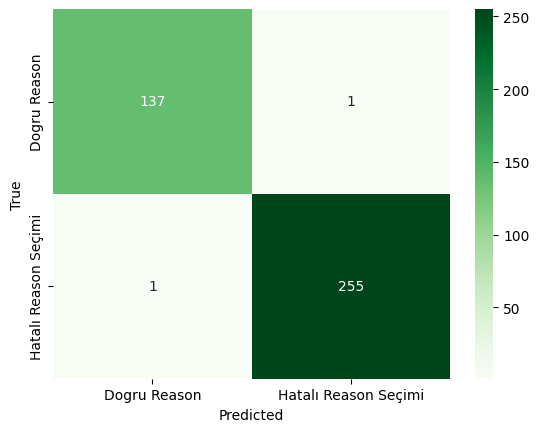

In [ ]:
# Modeli değerlendirme fonksiyonu
def evaluate_model(model, test_dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=-1).cpu().numpy())
            true_labels.extend(b_labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return accuracy

# Modeli test edelim
print("Model test ediliyor...")
test_accuracy = evaluate_model(model, test_dataloader)

# # Eğer model başarısı yeterli ise modeli kaydedelim
# if test_accuracy > 0.75:
#     print("Model yeterince başarılı, kaydediliyor...")
#     model.save_pretrained("/content/drive/MyDrive/MODELS/bert_finetuned_model_tested")
#     tokenizer.save_pretrained("/content/drive/MyDrive/MODELS/bert_finetuned_model_tested")
#     print("Model başarıyla kaydedildi.")
# else:
#     print("Model başarı seviyesi yeterli değil, yeniden eğitmek gerekebilir.")


In [ ]:
import numpy as np
import torch

# Varsayımlar:
# - X_test, test verilerini içeren bir Pandas DataFrame veya Series
# - y_test, gerçek etiketleri içeren bir NumPy dizisi
# - label_encoder, etiketleri kodlamak için kullanılan bir sklearn LabelEncoder nesnesi
# - tokenize_data, metinleri token'lara dönüştüren bir fonksiyon
# - model, tahmin yapmak için kullanılan bir PyTorch modeli
# - device, modelin üzerinde çalıştığı cihaz (CPU veya GPU)

def hatalari_yazdir(X_test, y_test, label_encoder, tokenize_data, model, device):
    hatali_ornekler = []

    for ix in range(len(X_test)):
        text = X_test.iloc[ix]
        true_label = label_encoder.classes_[y_test[ix]]

        token = tokenize_data(np.array([text]))
        b_input_ids, b_attention_mask = token["input_ids"].to(device), token["attention_mask"].to(device)
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, axis=-1).cpu().numpy()[0]
        predicted_label = label_encoder.classes_[pred]

        if true_label != predicted_label:
            hatali_ornekler.append({
                "metin": text,
                "gercek_deger": true_label,
                "tahmin_edilen_deger": predicted_label
            })

    if not hatali_ornekler:
        print("Tahminlerde hata bulunmamaktadır.")
    else:
        for ornek in hatali_ornekler:
            print("--------------------------------------------------")
            print(f"Metin: {ornek['metin']}")
            print(f"Gerçek Değer: {ornek['gercek_deger']}")
            print(f"Tahmin Edilen Değer: {ornek['tahmin_edilen_deger']}")

# Kullanım örneği:
hatalari_yazdir(X_test, y_test, label_encoder, tokenize_data, model, device)

--------------------------------------------------
Metin: Smothie bardağı aldım. Şarj aleti gelmedi. Rengi de farklı gelmişti onu sorun yapmadım. Geri iade etmek istedim ama kimse ilgilenmedi. Aradım ama hiçbir şekilde dönüş yapılamadı.
Gerçek Değer: Hatalı Reason Seçimi
Tahmin Edilen Değer: Dogru Reason
--------------------------------------------------
Metin: 43.5 diye aldım 43 numara cıktı rezalet
Gerçek Değer: Dogru Reason
Tahmin Edilen Değer: Hatalı Reason Seçimi


In [ ]:
import pandas as pd
from google.colab import files

def hatalari_yazdir_ve_kaydet(X_test, y_test, label_encoder, tokenize_data, model, device, dosya_adi="hatalar.xlsx"):
    hatali_ornekler = []

    for ix in range(len(X_test)):
        text = X_test.iloc[ix]
        true_label = label_encoder.classes_[y_test[ix]]

        token = tokenize_data(np.array([text]))
        b_input_ids, b_attention_mask = token["input_ids"].to(device), token["attention_mask"].to(device)
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, axis=-1).cpu().numpy()[0]
        predicted_label = label_encoder.classes_[pred]

        if true_label != predicted_label:
            hatali_ornekler.append({
                "Yorum": text,
                "Gerçek değer": true_label,
                "Tahmin değeri": predicted_label
            })

    if not hatali_ornekler:
        print("Tahminlerde hata bulunmamaktadır.")
    else:
        # Hatalı verileri DataFrame'e çevir
        hatali_df = pd.DataFrame(hatali_ornekler)

        # DataFrame'i Excel dosyasına kaydet
        hatali_df.to_excel(dosya_adi, index=False)
        print(f"Hatalı veriler {dosya_adi} olarak kaydedildi.")

        # Dosyayı Colab üzerinden indirme
        files.download(dosya_adi)

# Kullanım örneği:
hatalari_yazdir_ve_kaydet(X_test, y_test, label_encoder, tokenize_data, model, device, "hatalar.xlsx")


Hatalı veriler hatalar.xlsx olarak kaydedildi.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
evaluate_model(model, val_dataloader)

NameError: name 'val_dataloader' is not defined

In [ ]:
# LIME için yardımcı fonksiyon
def predictor(texts):
    if isinstance(texts, str):
        texts = [texts]
    token = tokenize_data(np.array(texts))
    b_input_ids, b_attention_mask = token["input_ids"].to(device), token["attention_mask"].to(device)
    outputs = model(b_input_ids, attention_mask=b_attention_mask)
    probabilities = outputs.logits
    return probabilities.cpu().detach().numpy()

In [ ]:
ix = 4
text = X_test.iloc[ix]
true_label = label_encoder.classes_[y_test[ix]]

token = tokenize_data(np.array([text]))
b_input_ids, b_attention_mask = token["input_ids"].to(device), token["attention_mask"].to(device)
outputs = model(b_input_ids, attention_mask=b_attention_mask)
logits = outputs.logits
pred = torch.argmax(logits, axis=-1).cpu().numpy()[0]
predicted_label = label_encoder.classes_[pred]
print(text)
print(f"Doğru:  {true_label}")
print(f"Tahmin: {predicted_label}")

DİĞER MAĞAZALARDAN AYAKKABI ALDIĞIM ZAMAN 3 ADET PARLATICI HEDİYE EDİYORLAR FAKAT FLO DAN AYAKKABI ALDIĞIMDA HİÇBİR HEDİYE OLMADIĞI HALDE, 50 LİRALIK PARLATICIYI 75 LİRAYA SATMAYA ÇALIŞTI KASİYER ÇALIŞAN. FLO GİBİ Bİ MAĞAZADAN BEKLENMEYECEK BİR DURUM...
Doğru:  Kampanya çeşitleri ve kapsamı arttırılmalı
Tahmin: Kampanya içeriği yeterince anlaşılır değil


In [ ]:
import numpy as np
ix = 7
text = X_test.iloc[ix]
true_label = label_encoder.classes_[y_test[ix]]

token = tokenize_data(np.array([text]))
outputs = model(b_input_ids, attention_mask=b_attention_mask)
logits = outputs.logits
pred = torch.argmax(logits, axis=-1).cpu().numpy()[0]
predicted_label = label_encoder.classes_[pred]
print(text)
print(f"Doğru:  {true_label}")
print(f"Tahmin: {predicted_label}")

2500 tl be üstünde 750 tl indirimde büyük bir terbiyesizlik yapmışsınız açıklayacılık yok kasada öğrendik gerçeği . Bundna sonra asla instreet den alışveriş yapmam, iptal etmeme sebebim arkadaşların yoğun ilgisiydi.
Doğru:  Kampanya içeriği yeterince anlaşılır değil
Tahmin: Kampanya içeriği yeterince anlaşılır değil


In [ ]:
y_test[ix],pred

(np.int64(3), np.int64(3))

In [ ]:
# predictor(text)

# Her bir sınıfın değerini yazdır
for i in range(0, 9):  # 0'dan 8'e kadar
    print(f"{i}. sınıf: {predictor(text)[0][i]:.4f}")

0. sınıf: -2.1225
1. sınıf: -1.0797
2. sınıf: -1.2214
3. sınıf: 3.1454
4. sınıf: 2.0307
5. sınıf: -1.4873
6. sınıf: -1.9643
7. sınıf: -1.1198
8. sınıf: 2.8894


In [ ]:

# Her bir sınıfın değerini yazdır
for i in range(0, 9):  # 0'dan 8'e kadar
    print(f"{label_encoder.classes_[i]}: {predictor(text)[0][i]:.4f}")

Aldığım ürünlerin fişi ayrı kesildiğinden kampanyadan yararlanamadım: -2.1225
Alışverişlerimde kart puanlarımı kullanamıyorum: -1.0797
Değişim / iade esnasında kampanya dikkate alınmadı: -1.2214
Kampanya içeriği yeterince anlaşılır değil: 3.1454
Kampanya süresi dolmasına rağmen etiketler güncellenmemiş: 2.0307
Kampanya çeşitleri ve kapsamı arttırılmalı: -1.4873
Kampanya öncesinde ürün fiyatlarında artış gerçekleştiriliyor: -1.9643
Kampanyanın geçerli olduğu ürün sayısı yetersizdi: -1.1198
Mağaza çalışanı kampanya hakkında bilgilendirmedi: 2.8894


In [ ]:
logits

tensor([[-2.4086, -2.1054, -1.6884,  4.3258,  2.6819, -1.1023, -1.6597,  0.2079,
         -0.0878]], grad_fn=<AddmmBackward0>)

In [ ]:
import shap
# SHAP açıklayıcıyı başlat
explainer = shap.Explainer(predictor, tokenizer)

# Açıklama oluştur
shap_values = explainer([text])

# Görselleştirme
shap.text_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:56, 116.74s/it]              


In [ ]:
import numpy as np
import torch

# Varsayımlar:
# - X_test, test verilerini içeren bir Pandas DataFrame veya Series
# - y_test, gerçek etiketleri içeren bir NumPy dizisi
# - label_encoder, etiketleri kodlamak için kullanılan bir sklearn LabelEncoder nesnesi
# - tokenize_data, metinleri token'lara dönüştüren bir fonksiyon
# - model, tahmin yapmak için kullanılan bir PyTorch modeli
# - device, modelin üzerinde çalıştığı cihaz (CPU veya GPU)

def hatalari_yazdir(X_test, y_test, label_encoder, tokenize_data, model, device):
    hatali_ornekler = []

    for ix in range(len(X_test)):
        text = X_test.iloc[ix]
        true_label = label_encoder.classes_[y_test[ix]]

        token = tokenize_data(np.array([text]))
        b_input_ids, b_attention_mask = token["input_ids"].to(device), token["attention_mask"].to(device)
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, axis=-1).cpu().numpy()[0]
        predicted_label = label_encoder.classes_[pred]

        if true_label != predicted_label:
            hatali_ornekler.append({
                "metin": text,
                "gercek_deger": true_label,
                "tahmin_edilen_deger": predicted_label
            })

    if not hatali_ornekler:
        print("Tahminlerde hata bulunmamaktadır.")
    else:
        for ornek in hatali_ornekler:
            print("--------------------------------------------------")
            print(f"Metin: {ornek['metin']}")
            print(f"Gerçek Değer: {ornek['gercek_deger']}")
            print(f"Tahmin Edilen Değer: {ornek['tahmin_edilen_deger']}")

# Kullanım örneği:
hatalari_yazdir(X_test, y_test, label_encoder, tokenize_data, model, device)

--------------------------------------------------
Metin: DİĞER MAĞAZALARDAN AYAKKABI ALDIĞIM ZAMAN 3 ADET PARLATICI HEDİYE EDİYORLAR FAKAT FLO DAN AYAKKABI ALDIĞIMDA HİÇBİR HEDİYE OLMADIĞI HALDE, 50 LİRALIK PARLATICIYI 75 LİRAYA SATMAYA ÇALIŞTI KASİYER ÇALIŞAN. FLO GİBİ Bİ MAĞAZADAN BEKLENMEYECEK BİR DURUM...
Gerçek Değer: Kampanya çeşitleri ve kapsamı arttırılmalı
Tahmin Edilen Değer: Mağaza çalışanı kampanya hakkında bilgilendirmedi
--------------------------------------------------
Metin: Bu maldan alırsanız 500 hediye çeki verilecek deniliyor,kasaya gidiyoruz hediye çekini daha sonraki alışverişinde kullanabilirsiniz deniliyor.Ben bir aya kadar oldu ya uğrayacağım. Bence kandırmaca uzat 5
Gerçek Değer: Kampanya çeşitleri ve kapsamı arttırılmalı
Tahmin Edilen Değer: Mağaza çalışanı kampanya hakkında bilgilendirmedi
--------------------------------------------------
Metin: Kasada orda ogün olmamasına rağmen başka bir çalışanınızı arayan bir müşteri onun tc kimlik numarası ile kasada

In [ ]:
import numpy as np
import torch
import pandas as pd

# Varsayımlar:
# - X_test, test verilerini içeren bir Pandas DataFrame veya Series
# - y_test, gerçek etiketleri içeren bir NumPy dizisi
# - label_encoder, etiketleri kodlamak için kullanılan bir sklearn LabelEncoder nesnesi
# - tokenize_data, metinleri token'lara dönüştüren bir fonksiyon
# - model, tahmin yapmak için kullanılan bir PyTorch modeli
# - device, modelin üzerinde çalıştığı cihaz (CPU veya GPU)

def hatalari_yazdir_ve_excel(X_test, y_test, label_encoder, tokenize_data, model, device, dosya_adi="hatalar.xlsx"):
    hatali_ornekler = []
    count = 0

    for ix in range(len(X_test)):
        text = X_test.iloc[ix]
        true_label = label_encoder.classes_[y_test[ix]]

        token = tokenize_data(np.array([text]))
        b_input_ids, b_attention_mask = token["input_ids"].to(device), token["attention_mask"].to(device)
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, axis=-1).cpu().numpy()[0]
        predicted_label = label_encoder.classes_[pred]

        if true_label != predicted_label:
            count += 1
            hatali_ornekler.append({
                "Metin": text,
                "Gerçek Değer": true_label,
                "Tahmin Edilen Değer": predicted_label
            })

    if not hatali_ornekler:
        print("Tahminlerde hata bulunmamaktadır.")
    else:
        # Hatalı örnekleri DataFrame'e dönüştür
        df_hatalar = pd.DataFrame(hatali_ornekler)

        # Hataları Excel dosyasına kaydet
        df_hatalar.to_excel("/content/drive/MyDrive/MODELS/yanlis_tahminler.xlsx", index=False)
        print(f"Hatalar {dosya_adi} dosyasına kaydedildi.")

# Kullanım örneği:
hatalari_yazdir_ve_excel(X_test, y_test, label_encoder, tokenize_data, model, device)


Hatalar hatalar.xlsx dosyasına kaydedildi.
